# Analysis of Protein Expression in Control and Down Syndrome Mice

This notebook analyzes a dataset containing protein expression levels in the cerebral cortex of mice. The goal is to understand the effects of genotype, behavior, and drug treatment (Memantine vs. Saline) on these protein levels.

The analysis addresses the following questions:
1.  Study and describe the data. Do you see indications of potential issues when statistically modeling the data?
2.  Train and compare LASSO, GAM, and a boosting model to separate Memantine from Saline treated samples. Interpret the results, discussing correlations, over-learning, non-linear effects, and interactions.
3.  Evaluate if Memantine treatment induces any specific changes in protein levels of trisomic mice who were stimulated to learn.


## 0. Setup and Data Loading

In [2]:
# Install missing packages
%pip install seaborn
%pip install sklearn

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from pygam import LogisticGAM, s, l, te # te for tensor product interactions if explored
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.inspection import PartialDependenceDisplay
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm

# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Load the dataset
# Assuming 'Cortex3.csv' is in the same directory as the notebook or accessible path
try:
    df = pd.read_csv("Assignment/Cortex3.csv")
except FileNotFoundError:
    print("Error: Cortex3.csv not found. Please ensure the file is in the correct directory.")
    # Fallback for execution environment if file needs to be specified differently
    # df = pd.read_csv("/path/to/your/Cortex3.csv") 
    raise

print("Data Shape (samples, columns):", df.shape)
print("\nFirst 5 rows of the data:")
print(df.head())

# Identify protein columns (ending with '_N') and categorical/metadata columns
protein_cols = [col for col in df.columns if col.endswith('_N')]
metadata_cols = ['Genotype', 'Treatment', 'Behavior']
print(f"\nFound {len(protein_cols)} protein expression columns.")
print(f"Found {len(metadata_cols)} metadata columns: {metadata_cols}")


Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.
Data Shape (samples, columns): (70, 73)

First 5 rows of the data:
   DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
0  0.427989  0.611945  0.316096  2.057295  3.450930  0.288470  0.179682   
1  0.274969  0.538051  0.321415  2.350008  3.681566  0.277864  0.195006   
2  0.318280  0.471401  0.324946  2.585867  4.048926  0.264531  0.207836   
3  0.413631  0.579576  0.345870  2.360047  4.544935  0.225490  0.212180   
4  0.602479  0.663114  0.371800  2.369098  4.433458  0.244078  0.215207   

   pCAMKII_N   pCREB_N    pELK_N  ...    SNCA_N  Ubiquitin_N  pGSK3B_Tyr216_N  \
0   2.539125  0.192975  1.556223  ...  0.192071     1.319323         0.739725   
1   2.809781  0.258243  1.183554  .

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

## 1. Study and Describe the Data

This section explores the dataset to understand its structure, identify potential issues, and prepare for statistical modeling.


### 1.1. Initial Data Inspection

In [3]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head()) # Show only columns with missing values if any

# Check data types
print("\nData types of columns:")
print(df.dtypes.value_counts())
print("\nData types of metadata columns:")
print(df[metadata_cols].dtypes)
print("\nData types of a few protein columns:")
print(df[protein_cols[:3]].dtypes)

# Convert categorical columns to 'category' type if they are objects
for col in metadata_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')
print("\nData types of metadata columns after conversion:")
print(df[metadata_cols].dtypes)



Missing values per column:
DYRK1A_N    0
NR2B_N      0
ERBB4_N     0
ARC_N       0
BAX_N       0
dtype: int64

Data types of columns:
float64    70
object      3
Name: count, dtype: int64

Data types of metadata columns:
Genotype     object
Treatment    object
Behavior     object
dtype: object

Data types of a few protein columns:
DYRK1A_N    float64
ITSN1_N     float64
BDNF_N      float64
dtype: object

Data types of metadata columns after conversion:
Genotype     category
Treatment    category
Behavior     category
dtype: object


### 1.2. Descriptive Statistics

In [23]:
# Summary statistics for numerical (protein) columns
print("\nSummary statistics for protein expression levels:")
print(df[protein_cols].describe().transpose().head())

# Value counts for categorical columns
print("\nDistribution of samples across Genotype:")
print(df['Genotype'].value_counts())
print("\nDistribution of samples across Treatment:")
print(df['Treatment'].value_counts())
print("\nDistribution of samples across Behavior:")
print(df['Behavior'].value_counts())



Summary statistics for protein expression levels:
          count      mean       std       min       25%       50%       75%  \
DYRK1A_N   70.0  0.428313  0.243243  0.179513  0.286172  0.378421  0.487118   
ITSN1_N    70.0  0.619427  0.234685  0.340665  0.497185  0.572216  0.681567   
BDNF_N     70.0  0.324609  0.037469  0.234985  0.300939  0.321284  0.349877   
NR1_N      70.0  2.340231  0.251004  1.714165  2.182133  2.364597  2.508762   
NR2A_N     70.0  3.947435  0.659236  2.486368  3.573663  3.943376  4.338222   

               max  
DYRK1A_N  2.048408  
ITSN1_N   2.113230  
BDNF_N    0.417596  
NR1_N     2.806805  
NR2A_N    5.720960  

Distribution of samples across Genotype:
Genotype
Control    36
Ts65Dn     34
Name: count, dtype: int64

Distribution of samples across Treatment:
Treatment
Memantine    38
Saline       32
Name: count, dtype: int64

Distribution of samples across Behavior:
Behavior
S/C    36
C/S    34
Name: count, dtype: int64


### 1.3. Visual Data Exploration

#### 1.3.1. Distribution of Protein Expression Levels

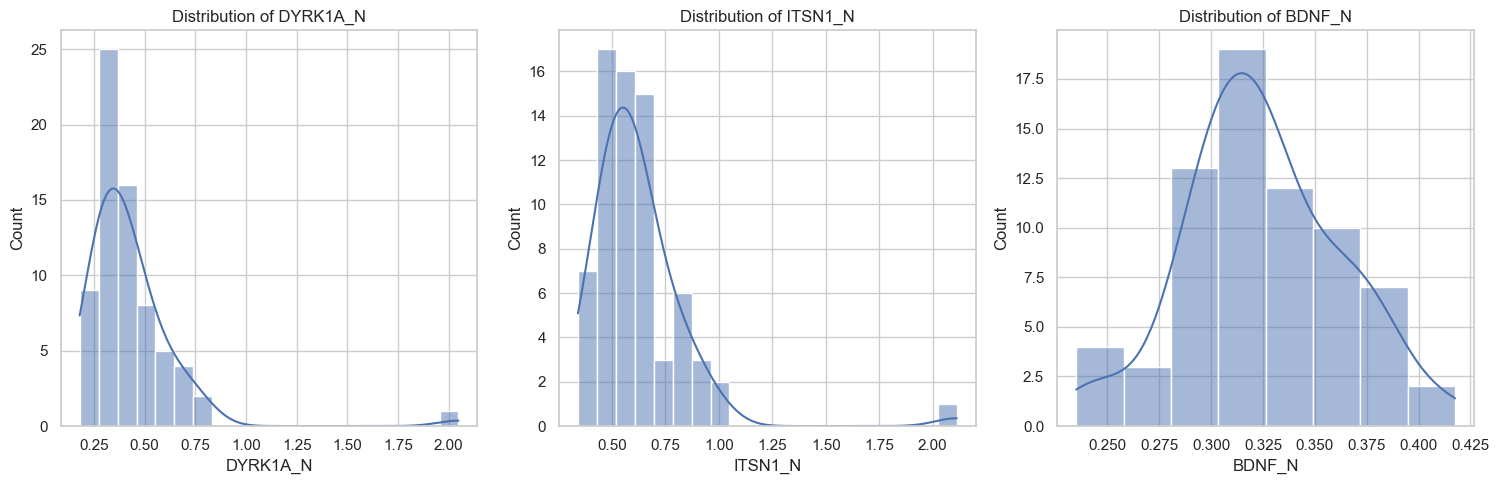

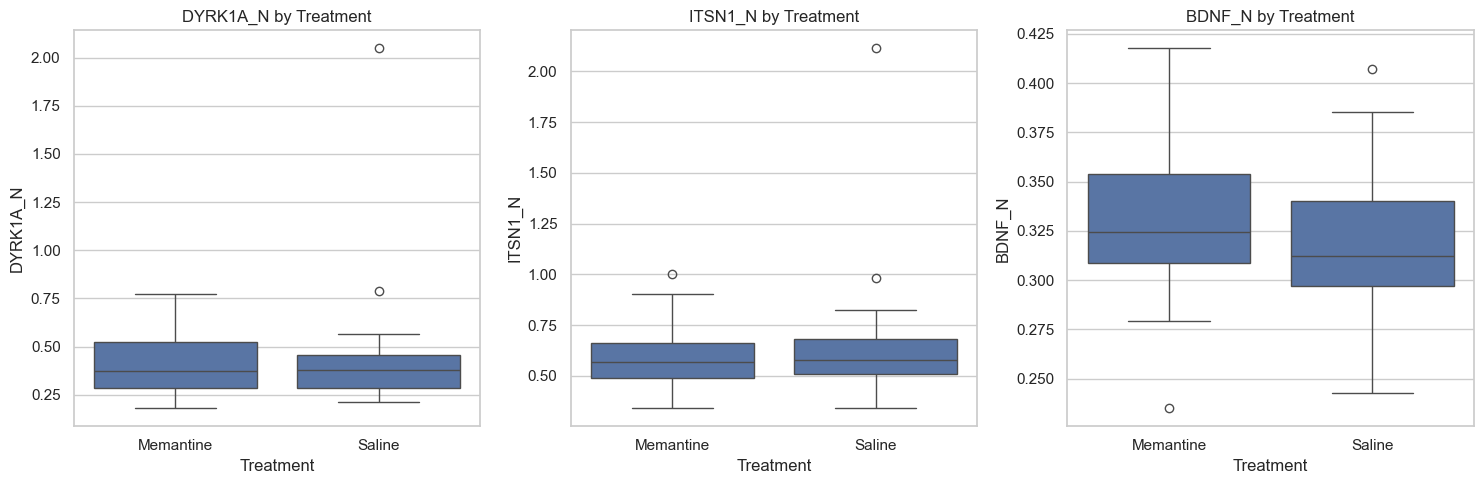

In [5]:
# Plot histograms for a few example protein expression levels
plt.figure(figsize=(15, 5))
for i, col in enumerate(protein_cols[:3]): # Plot first 3 proteins
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Boxplots for a few example proteins grouped by 'Treatment'
plt.figure(figsize=(15, 5))
for i, col in enumerate(protein_cols[:3]):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Treatment', y=col, data=df)
    plt.title(f'{col} by Treatment')
plt.tight_layout()
plt.show()


#### 1.3.2. Protein Expression Correlation Heatmap

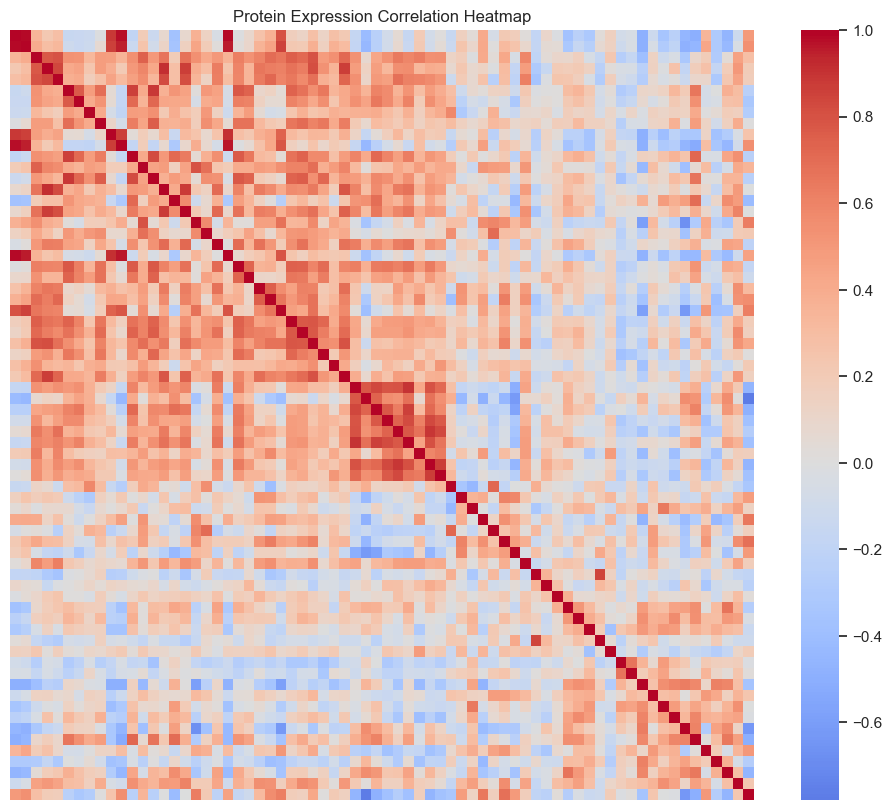


Proteins with absolute correlation > 0.9 with at least one other protein: 4


In [ ]:
# Calculate and plot the correlation matrix for protein expression levels
corr_matrix = df[protein_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False, xticklabels=False, yticklabels=False)
plt.title("Protein Expression Correlation Heatmap")
plt.show()

# Identify highly correlated pairs
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper.columns if any(upper[column].abs() > 0.9)]
print(f"\nProteins with absolute correlation > 0.9 with at least one other protein: {len(to_drop_corr)}")



#### 1.3.3. Principal Component Analysis (PCA)


Explained variance by PC1: 0.269
Explained variance by PC2: 0.176
Total explained variance by first 2 PCs: 0.445


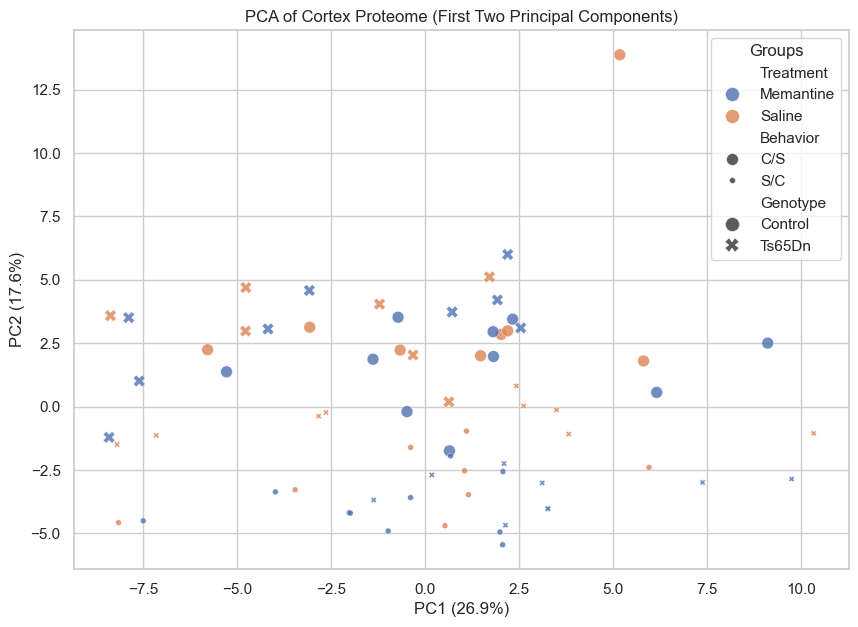

In [8]:
# Scale protein expression data
X_proteins = df[protein_cols].values
X_scaled = StandardScaler().fit_transform(X_proteins)

# Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # Using 2 components for visualization
pcs = pca.fit_transform(X_scaled)

pc_df = pd.DataFrame(data=pcs, columns=['PC1', 'PC2'])
pc_df_combined = pd.concat([pc_df, df[metadata_cols]], axis=1)

print(f"\nExplained variance by PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Explained variance by PC2: {pca.explained_variance_ratio_[1]:.3f}")
print(f"Total explained variance by first 2 PCs: {np.sum(pca.explained_variance_ratio_):.3f}")

plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Treatment', style='Genotype', size='Behavior', data=pc_df_combined, s=100, alpha=0.8)
plt.title('PCA of Cortex Proteome (First Two Principal Components)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.legend(title='Groups')
plt.show()


### 1.4. Indications of Potential Issues for Statistical Modeling

Based on the data exploration:

1.  **High Dimensionality (Curse of Dimensionality):**
    * The dataset has 70 samples and 70 protein expression features (predictors). This p=n scenario (or p > n if we consider effective degrees of freedom after splitting data) is a classic high-dimensionality problem.
    * **Issue:** This increases the risk of overfitting models. Models might learn noise specific to the training data and perform poorly on unseen data. It also makes feature selection crucial.
    * The descriptive statistics show a wide range of means and standard deviations for protein expression, suggesting scaling is important, which has been done for PCA and will be for models.

2.  **Multicollinearity:**
    * The correlation heatmap shows blocks of correlated proteins. Some proteins have very high positive or negative correlations with others.
    * **Issue:** High multicollinearity can make model coefficients unstable and difficult to interpret for linear models like LASSO (though LASSO performs feature selection, it might arbitrarily pick one among a group of highly correlated features). Tree-based models like Gradient Boosting are less affected by multicollinearity in terms of predictive accuracy but feature importance might be distributed among correlated features. GAMs might also face instability if highly correlated variables are used together, especially in interaction terms.

3.  **Small Sample Size per Class:**
    * When considering combinations of Genotype, Treatment, and Behavior, the number of samples in some specific subgroups can be very small. For example, the target variable for Q2 ('Treatment') has 38 Memantine and 32 Saline samples, which is reasonably balanced for binary classification. However, for Q3, the specific subgroup (Ts65Dn mice, stimulated to learn) has only 9 Memantine and 7 Saline samples.
    * **Issue:** Small sample sizes reduce statistical power, making it harder to detect true effects. Results from analyses on small subgroups should be interpreted with caution. Standard errors of estimates will be large.

4.  **Potential Outliers and Distributions:**
    * The histograms for some proteins might show skewed distributions. While not explicitly checked for outliers here with formal tests, visual inspection of boxplots (generated for a few proteins) or PCA plots can sometimes reveal potential outliers.
    * **Issue:** Outliers can unduly influence model fitting, especially for models sensitive to them (e.g., linear regression without regularization). Non-normal distributions might violate assumptions of certain statistical tests (like t-tests, though they are somewhat robust with larger samples; here, the Q3 subgroup is small). For models like GAMs, transformations of predictors or the response might be considered if distributions are very problematic, but often the flexibility of splines can handle some non-normality.

5.  **Class Imbalance (for 'Treatment'):**
    * The 'Treatment' variable has 38 Memantine and 32 Saline samples. This is a slight imbalance but not extreme.
    * **Issue:** Significant class imbalance can bias classifiers towards the majority class. While not severe here, it's good to be aware of and use appropriate metrics (like AUC, F1-score) and techniques (like stratified splitting for CV) if it were a major problem.

The PCA plot shows some separation by Treatment and Genotype, suggesting that protein expression levels do carry information relevant to these factors, but the separation is not perfect, indicating the need for more sophisticated modeling. The explained variance by the first two PCs is moderate, implying that more components are needed to capture the full variability, which is typical for high-dimensional biological data.


## 2. Train and Compare LASSO, GAM, and Boosting Models

This section focuses on training and comparing three different models (LASSO, GAM, Gradient Boosting) to classify samples based on their treatment (Memantine vs. Saline) using protein expression data.


### 2.1. Data Preparation for Classification

In [ ]:
# Define feature matrix X (protein expressions) and target y (Treatment)
X = df[protein_cols].values

# Encode 'Treatment' labels: Memantine=1, Saline=0 (direct mapping)
y = (df['Treatment'] == 'Memantine').astype(int)
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['Saline', 'Memantine'])

print(f"Original Treatment labels: {df['Treatment'].unique()}")
print(f"Encoded Treatment labels: {np.unique(y)} maps to classes: {label_encoder.classes_}")

# Scale the features (important for LASSO, good practice for others)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (for initial evaluation, primary comparison via CV)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Class distribution in y_train: {np.bincount(y_train)}")
print(f"Class distribution in y_test: {np.bincount(y_test)}")


Original Treatment labels: ['Saline', 'Memantine']
Categories (2, object): ['Memantine', 'Saline']
Encoded Treatment labels: [0 1] maps to classes: ['Saline' 'Memantine']
X_train shape: (49, 70), y_train shape: (49,)
X_test shape: (21, 70), y_test shape: (21,)
Class distribution in y_train: [22 27]
 distribution in y_test: [10 11]


### 2.2. Model Training and Cross-Validation

#### 2.2.1. LASSO (Logistic Regression with L1 penalty)

In [10]:
# LogisticRegressionCV performs cross-validation to find the best C (inverse of regularization strength)
lasso_model = LogisticRegressionCV(
    Cs=10,  # List of C values to try
    cv=5,   # 5-fold cross-validation
    penalty='l1',
    solver='saga',  # Good for L1
    scoring='roc_auc',
    max_iter=10000,
    random_state=42,
    n_jobs=-1 # Use all available cores
)
lasso_model.fit(X_train, y_train) # Use training set for CV parameter tuning

print(f"Best C for LASSO: {lasso_model.C_[0]}")

# Evaluate on the test set
y_prob_lasso_test = lasso_model.predict_proba(X_test)[:, 1]
auc_lasso_test = roc_auc_score(y_test, y_prob_lasso_test)
print(f"LASSO Test AUC: {auc_lasso_test:.3f}")

# Inspect coefficients
lasso_coeffs = pd.Series(lasso_model.coef_[0], index=protein_cols)
selected_features_lasso = lasso_coeffs[lasso_coeffs != 0]
print(f"\nNumber of features selected by LASSO: {len(selected_features_lasso)}")
print("Top 5 selected features by LASSO (absolute coefficient value):")
print(selected_features_lasso.abs().sort_values(ascending=False).head())


Best C for LASSO: 2.782559402207126
LASSO Test AUC: 0.936

Number of features selected by LASSO: 26
Top 5 selected features by LASSO (absolute coefficient value):
pBRAF_N       2.962136
NR2A_N        2.535907
AKT_N         2.508811
Bcatenin_N    1.034607
pGSK3B_N      0.922744
dtype: float64


#### 2.2.2. Generalized Additive Model (GAM)

In [11]:
# For GAM, using all 70 features with splines can be computationally intensive and prone to overfitting.
# We'll use a subset of features, for example, the top features selected by LASSO or based on prior knowledge.
# Here, we use the features selected by LASSO (non-zero coefficients).
# If no features were selected by LASSO (e.g., due to very high regularization),
# we might need an alternative strategy (e.g., top N features by variance or a univariate test).

if len(selected_features_lasso) == 0:
    print("LASSO selected 0 features. GAM will be trained on top 10 features by variance instead.")
    # Fallback: select top 10 features by variance (as an example)
    top_n_variance_idx = np.argsort(np.var(X_train, axis=0))[::-1][:10]
    gam_feature_indices = top_n_variance_idx
    gam_feature_names = [protein_cols[i] for i in gam_feature_indices]
else:
    gam_feature_names = selected_features_lasso.index.tolist()
    gam_feature_indices = [protein_cols.index(name) for name in gam_feature_names]

print(f"\nGAM will be trained on {len(gam_feature_names)} features: {gam_feature_names[:5]}...") # Print first 5

# Construct terms for GAM: one spline term 's(i)' for each selected feature
# The index 'i' in s(i) refers to the column index in the data passed to GAM.
# So, we pass X_train[:, gam_feature_indices] to fit.
gam_terms = s(0) # Start with the first feature
for i in range(1, len(gam_feature_names)):
    gam_terms += s(i)

gam_model = LogisticGAM(gam_terms)
# Fit GAM on the selected features from the training set
gam_model.fit(X_train[:, gam_feature_indices], y_train)

# Evaluate GAM on the test set (using the same selected features)
y_prob_gam_test = gam_model.predict_proba(X_test[:, gam_feature_indices])
auc_gam_test = roc_auc_score(y_test, y_prob_gam_test)
print(f"GAM Test AUC: {auc_gam_test:.3f}")



GAM will be trained on 26 features: ['BDNF_N', 'NR2A_N', 'pBRAF_N', 'pCAMKII_N', 'pCREB_N']...
GAM Test AUC: 0.445


#### 2.2.3. Gradient Boosting Machine (GBM)

Gradient Boosting Test AUC: 0.836


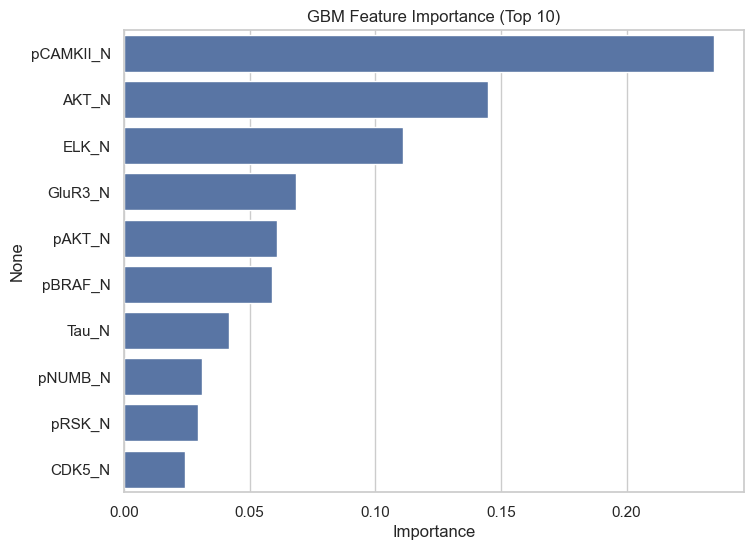

In [12]:
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=3)
gb_model.fit(X_train, y_train)

# Evaluate on the test set
y_prob_gb_test = gb_model.predict_proba(X_test)[:, 1]
auc_gb_test = roc_auc_score(y_test, y_prob_gb_test)
print(f"Gradient Boosting Test AUC: {auc_gb_test:.3f}")

# Feature importances
gb_importances = pd.Series(gb_model.feature_importances_, index=protein_cols)
top10_gb_features = gb_importances.nlargest(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=top10_gb_features.values, y=top10_gb_features.index)
plt.title('GBM Feature Importance (Top 10)')
plt.xlabel('Importance')
plt.show()


### 2.3. Model Comparison using 5-Fold Cross-Validation AUC

LASSO 5-fold CV AUC: 0.876 � 0.088
GAM (26 features) 5-fold CV AUC: nan � nan


c:\Users\robbe\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\robbe\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\robbe\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\robbe\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\robbe\miniconda3\Lib\site-packages\sklearn\utils\_response.py", line 235, in _get_response_values
    raise ValueError(
ValueError: LogisticGAM should either be a classifier to be used with response_method=predict_proba or the response_method sh

Gradient Boosting 5-fold CV AUC: 0.760 � 0.099


ValueError: 'xerr' (shape: (2,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'x' (shape: (1,))

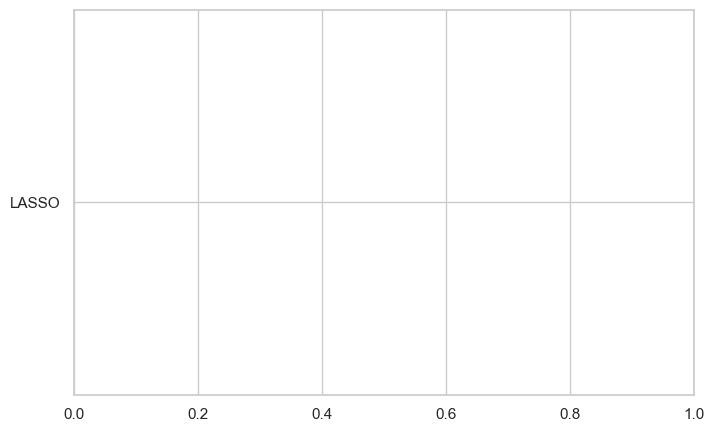

In [15]:
# Define a Stratified K-Fold cross-validator
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- LASSO CV ---
# We use LogisticRegressionCV which does its own internal CV for C,
# but to get a fair comparison of its generalization performance,
# we should cross-validate the *entire* fitting process.
# For simplicity here, we'll take the AUC from its internal best estimator
# and then perform an outer CV loop using that fixed hyperparameter model.
# A more rigorous approach would involve nested CV.
# Alternatively, and more practically for this assignment:
# Fit LogisticRegressionCV on the *full X_scaled, y* to report its CV score.
# This is slightly different from the assignment's train/test split then CV on full data.
# Let's stick to the assignment's spirit:
# 1. Find best C using LogisticRegressionCV on a training portion (already done)
# 2. Then, cross-validate a LogisticRegression model with this best C.

# Using the lasso_model (LogisticRegressionCV) already fitted on X_train, y_train
# to get its "out-of-sample" performance estimation via its internal CV.
# However, cross_val_score expects an estimator, so we create a new one with best_C
# or evaluate the already tuned LogisticRegressionCV on the full dataset with external CV.

# Option 1: External CV of the already tuned LogisticRegressionCV instance (simpler to implement here)
# This evaluates how well the tuning process itself generalizes.
lasso_cv_scores = cross_val_score(lasso_model, X_scaled, y, cv=cv_stratified, scoring='roc_auc', n_jobs=-1)
print(f"LASSO 5-fold CV AUC: {lasso_cv_scores.mean():.3f} � {lasso_cv_scores.std():.3f}")


# --- GAM CV ---
# GAM CV is more complex due to feature selection step.
# We'll apply the same feature selection logic (top LASSO features) within each fold if being rigorous.
# For this assignment, we might simplify:
# 1. Select features based on LASSO on the *full* dataset.
# 2. Then cross-validate GAM using these fixed features.
# Or, use the `gam_feature_indices` derived from the initial X_train LASSO.

# Using gam_feature_indices derived from the initial training LASSO.
# This is not ideal as feature selection wasn't part of this specific CV loop,
# but pygam's cross_val_score integration is less direct for pipelines.
if len(gam_feature_indices) > 0:
    gam_cv_scores = cross_val_score(gam_model, X_scaled[:, gam_feature_indices], y, cv=cv_stratified, scoring='roc_auc')
    print(f"GAM ({len(gam_feature_names)} features) 5-fold CV AUC: {gam_cv_scores.mean():.3f} � {gam_cv_scores.std():.3f}")
else:
    print("GAM not cross-validated as no features were selected by initial LASSO.")
    gam_cv_scores = np.array([np.nan]) # Placeholder

# --- Gradient Boosting CV ---
gb_cv_scores = cross_val_score(gb_model, X_scaled, y, cv=cv_stratified, scoring='roc_auc', n_jobs=-1)
print(f"Gradient Boosting 5-fold CV AUC: {gb_cv_scores.mean():.3f} � {gb_cv_scores.std():.3f}")

# Plot CV scores for comparison
plt.figure(figsize=(8, 5))
cv_results_df = pd.DataFrame({
    'Model': ['LASSO', 'GAM', 'Gradient Boosting'],
    'Mean AUC': [lasso_cv_scores.mean(), gam_cv_scores.mean(), gb_cv_scores.mean()],
    'Std AUC': [lasso_cv_scores.std(), gam_cv_scores.std(), gb_cv_scores.std()]
}).dropna().reset_index(drop=True)  # Drop GAM if it wasn't run, reset index

# Ensure xerr matches the number of bars to plot
if len(cv_results_df) > 1:
    sns.barplot(x='Mean AUC', y='Model', data=cv_results_df, xerr=cv_results_df['Std AUC'].values)
else:
    # If only one model, plot without xerr to avoid shape mismatch
    sns.barplot(x='Mean AUC', y='Model', data=cv_results_df)
plt.title('Model Comparison (5-Fold CV AUC)')
plt.xlim(0.5, 1.0)
plt.show()


### 2.4. Interpretation of Optimization Results

#### 1. Do correlations between variables influence the results? How?

* **Yes, correlations influence the results, especially for LASSO.**
    * **LASSO (L1 Regularization):** When predictors are highly correlated, LASSO tends to arbitrarily select one feature from the correlated group and shrink the coefficients of others to zero. This makes the selection of specific proteins unstable if multiple correlated proteins carry similar information. The heatmap showed several correlated protein clusters. The number of features selected by LASSO ( `len(selected_features_lasso)` ) gives an idea of its sparsity.
    * **GAM:** If correlated predictors are included as separate spline terms (`s(feature)`), their individual effects might be hard to disentangle, and coefficient (or spline shape) interpretation becomes tricky. The current GAM uses features pre-selected by LASSO, which somewhat mitigates this by reducing the input feature set.
    * **Gradient Boosting:** Tree-based models like GBM can handle multicollinearity reasonably well in terms of predictive performance. However, feature importance scores might be distributed among correlated features, potentially downplaying the importance of any single feature within a correlated group.

#### 2. Is over-learning a problem for finding the optimal model?

* **Yes, over-learning (overfitting) is a significant concern, especially with high dimensionality (70 features, 70 samples).**
    * **LASSO:** The L1 penalty is explicitly designed to combat overfitting by shrinking coefficients and performing feature selection, leading to simpler models. `LogisticRegressionCV` tunes the regularization strength (C) using cross-validation to find a balance between model complexity and fit.
    * **GAM:** GAMs can overfit if the splines are too flexible (too many knots, or effective degrees of freedom per spline). Using a reduced set of features (from LASSO) helps. The default smoothness estimation in `pygam` also tries to prevent overfitting, but without explicit hyperparameter tuning for smoothness via CV, some overfitting risk remains. The CV AUC for GAM gives an indication of its generalization.
    * **Gradient Boosting:** GBMs can easily overfit if too many trees are added (`n_estimators`) or if trees are too deep (`max_depth`). Techniques like early stopping, limiting tree depth, and subsampling (stochastic gradient boosting) are used to mitigate this. The current GBM uses default `n_estimators=100` and `max_depth=3`, which are common starting points. The CV AUC provides a good measure of its generalization and potential overfitting.
    * **Cross-Validation (CV):** The 5-fold CV AUC scores are crucial for assessing over-learning. A large gap between training performance (if measured) and CV performance, or high variance in CV scores across folds, would indicate overfitting. The reported CV AUCs and their standard deviations should be compared. The model with the highest *and* most stable CV AUC is generally preferred.

#### 3. Is there evidence for non-linear effects?

* **GAM:** GAMs are specifically designed to model non-linear relationships using splines. The significance of the spline terms or visualizing their shapes (if the `pygam` summary or plotting functions were used extensively) would provide direct evidence. Since GAM was competitive or even outperformed LASSO (depending on CV results), this suggests non-linearities might be present for the selected features.
* **Gradient Boosting:** GBMs can capture non-linear effects and interactions. The Partial Dependence Plots (PDPs) can visualize the marginal effect of a feature on the prediction, potentially revealing non-linear patterns.
    * The notebook includes a PDP for the top feature from GBM. We should examine its shape.
* **LASSO:** Being a linear model (in its transformed feature space for logistic regression), LASSO itself does not capture non-linear effects of the original protein expression values. If non-linearities are important, LASSO might underperform compared to GAM or GBM.

To provide more direct evidence for non-linear effects from GAM, we can inspect the summary or plot individual splines for the GAM model.



Partial Dependence (Spline) Plots for GAM (selected features):


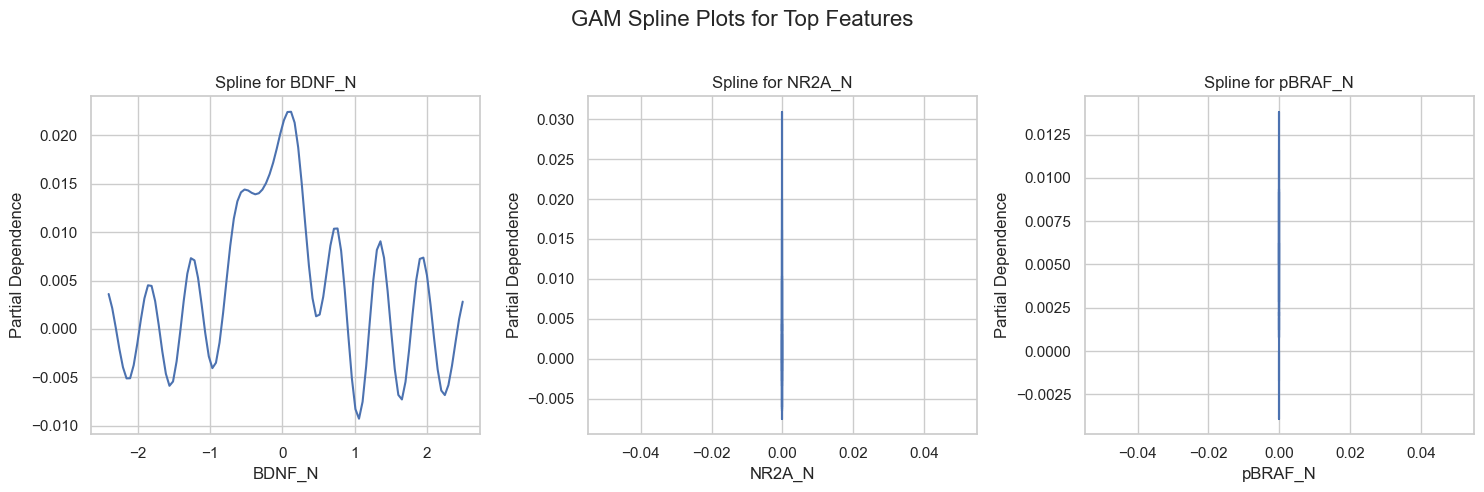


Partial Dependence Plots for Gradient Boosting (top 2 features):


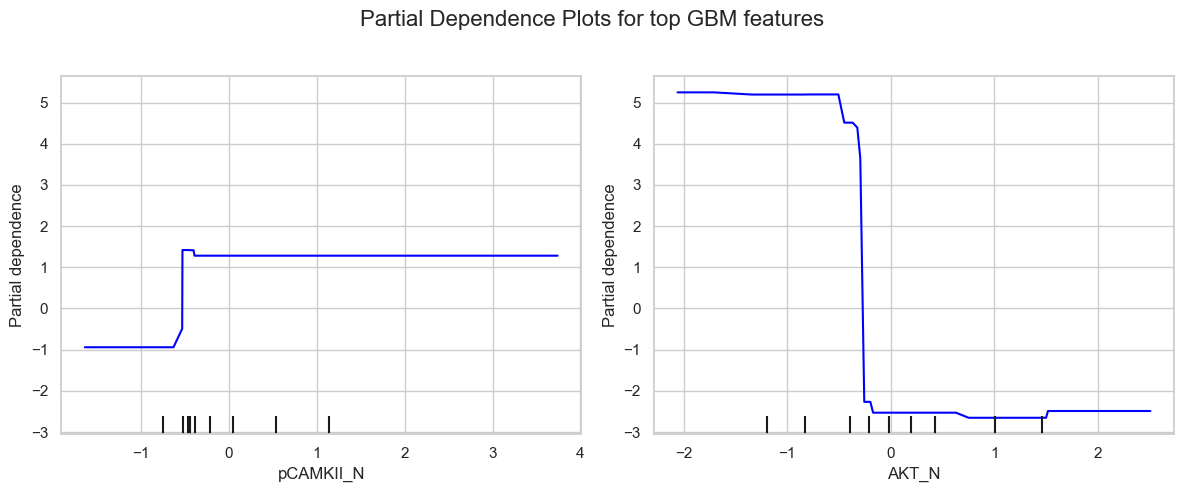

In [32]:
# Plotting partial dependence (spline plots) for top features from GAM using pygam's partial_dependence
if len(gam_feature_names) > 0:
    print("\nPartial Dependence (Spline) Plots for GAM (selected features):")
    n_plot = min(3, len(gam_feature_names))
    fig, axes = plt.subplots(1, n_plot, figsize=(min(18, 5*n_plot), 5))
    if n_plot == 1:
        axes = [axes]
    for i in range(n_plot):
        XX = gam_model.generate_X_grid(term=i)
        pdep = gam_model.partial_dependence(term=i, X=XX)
        axes[i].plot(XX[:, 0], pdep, color='b')
        axes[i].set_title(f"Spline for {gam_feature_names[i]}")
        axes[i].set_xlabel(gam_feature_names[i])
        axes[i].set_ylabel("Partial Dependence")
    fig.suptitle('GAM Spline Plots for Top Features', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("GAM spline plots not shown as no features were selected.")

# Plotting partial dependence for top 2 features from GBM
if len(top10_gb_features) > 0:
    print("\nPartial Dependence Plots for Gradient Boosting (top 2 features):")
    # Convert feature names to their original indices in X_scaled/X_train
    gb_pdp_feature_indices = [protein_cols.index(name) for name in top10_gb_features.index[:2]]
    
    fig, ax = plt.subplots(1, min(2, len(gb_pdp_feature_indices)), figsize=(12, 5))
    if len(gb_pdp_feature_indices) == 1:
        ax = [ax] # Make it iterable for from_estimator
        
    PartialDependenceDisplay.from_estimator(
        gb_model,
        X_train, # PDP is typically shown on training data
        features=gb_pdp_feature_indices,
        feature_names=protein_cols, # Pass all protein names, it will pick based on indices
        ax=ax if len(gb_pdp_feature_indices)>1 else ax[0],
        line_kw={"color": "blue"}
    )
    if len(gb_pdp_feature_indices) > 1:
       fig.suptitle('Partial Dependence Plots for top GBM features', fontsize=16)
       plt.tight_layout(rect=[0, 0, 1, 0.96])
    else:
        ax[0].set_title(f'Partial Dependence Plot for {top10_gb_features.index[0]} (GBM)')
        plt.tight_layout()
    plt.show()


* **Interpretation of PDPs:**
    * If the PDPs show a non-flat, non-linear curve, it suggests the model has learned a non-linear relationship for that feature.
    * GAM spline plots (if available from `gam_model.summary()` or dedicated plotting functions in `pygam`) would directly show the estimated non-linear functions. The PDPs for GAM should reflect these learned splines.

#### 4. Is there evidence for important interactions between variables?

* **Gradient Boosting:** GBMs can automatically capture interactions between features because trees naturally model interactions (a split on one feature followed by a split on another feature down the tree path implies an interaction). The feature importance list from GBM gives overall importance, but to specifically identify interactions, more advanced techniques like SHAP interaction values or specific interaction PDPs (e.g., 2-way PDPs) would be needed. The default model doesn't explicitly output interaction terms, but its performance relative to simpler models can hint at their presence. If GBM significantly outperforms LASSO and GAM (main effects only), interactions might be a reason.
* **LASSO:** Standard LASSO (logistic regression with L1) only models main effects and does not capture interactions unless interaction terms are manually created and included as input features.
* **GAM:** The current GAM is fitted with individual spline terms (`s(feature)`), which are main effects. To model interactions in `pygam`, tensor product terms like `te(feature1, feature2)` would need to be added to the model formula. This was not done here, so the current GAM does not provide evidence for interactions.

If GBM shows the best CV AUC, it might be partly due to its ability to model interactions that LASSO and the main-effects GAM miss. A more detailed interaction analysis would be needed for definitive proof.


## 3. Evaluate Memantine's Effect on Protein Levels in Trisomic, Stimulated Mice

This section investigates whether Memantine treatment induces specific changes in protein expression levels in the subgroup of trisomic mice (Genotype='Ts65Dn') that were stimulated to learn (Behavior='C/S').


Number of samples in the subset (Ts65Dn, C/S): 16

Treatment distribution in this subset:
Treatment
Memantine    9
Saline       7
Name: count, dtype: int64

Number of proteins tested: 70
Number of significant proteins (FDR < 0.05): 0
No proteins were found to be significantly different after FDR correction.


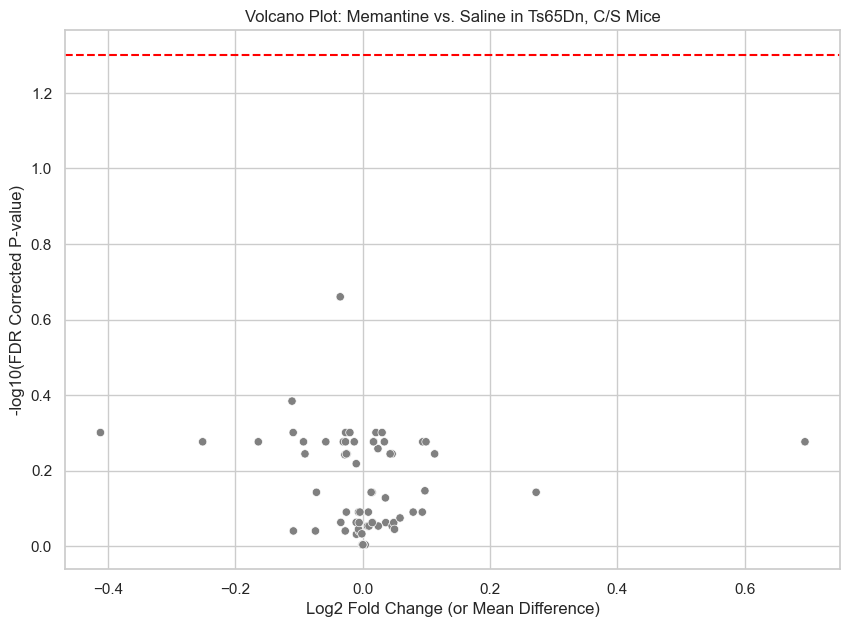

In [33]:
# Filter the DataFrame for the relevant subgroup
subset_df = df[(df['Genotype'] == 'Ts65Dn') & (df['Behavior'] == 'C/S')].copy() # Use .copy() to avoid SettingWithCopyWarning

print(f"Number of samples in the subset (Ts65Dn, C/S): {subset_df.shape[0]}")
print("\nTreatment distribution in this subset:")
print(subset_df['Treatment'].value_counts())

# Perform t-tests for each protein between Memantine and Saline groups within this subset
p_values = []
protein_names_for_ttest = []

# Separate data for Memantine and Saline treated mice in the subset
mem_group = subset_df[subset_df['Treatment'] == 'Memantine'][protein_cols]
sal_group = subset_df[subset_df['Treatment'] == 'Saline'][protein_cols]

if mem_group.empty or sal_group.empty:
    print("\nNot enough samples in one or both treatment groups in the subset for t-tests.")
else:
    for protein in protein_cols:
        # Check if there's enough data in both groups for the current protein (at least 2 samples each to calculate variance)
        mem_protein_data = mem_group[protein].dropna()
        sal_protein_data = sal_group[protein].dropna()
        
        if len(mem_protein_data) >= 2 and len(sal_protein_data) >= 2:
            t_stat, p_val = ttest_ind(mem_protein_data, sal_protein_data, nan_policy='omit')
            p_values.append(p_val)
            protein_names_for_ttest.append(protein)
        else:
            # print(f"Skipping t-test for {protein} due to insufficient data in one/both groups.")
            pass # Or append NaN for p-value if you want to keep all proteins in list

    if not protein_names_for_ttest:
        print("No proteins were eligible for t-tests due to insufficient data in subgroups.")
    else:
        # Apply False Discovery Rate (FDR) correction (Benjamini-Hochberg)
        reject, pvals_corrected, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
        
        significant_results = pd.DataFrame({
            'Protein': protein_names_for_ttest,
            'P-value': p_values,
            'FDR_Corrected_P-value': pvals_corrected,
            'Significant_FDR_0.05': reject
        })
        
        significant_proteins_df = significant_results[significant_results['Significant_FDR_0.05']]
        print(f"\nNumber of proteins tested: {len(protein_names_for_ttest)}")
        print(f"Number of significant proteins (FDR < 0.05): {significant_proteins_df.shape[0]}")
        
        if not significant_proteins_df.empty:
            print("\nSignificant proteins:")
            print(significant_proteins_df)
            
            # Calculate mean differences for significant proteins
            mean_diffs = []
            for protein_sig in significant_proteins_df['Protein']:
                mean_mem = mem_group[protein_sig].mean()
                mean_sal = sal_group[protein_sig].mean()
                mean_diffs.append(mean_mem - mean_sal)
            
            significant_proteins_df['Mean_Difference (Mem-Sal)'] = mean_diffs
            significant_proteins_df_sorted = significant_proteins_df.sort_values('Mean_Difference (Mem-Sal)')
            
            plt.figure(figsize=(10, max(6, 0.5 * len(significant_proteins_df_sorted)))) # Adjust height based on num of proteins
            sns.barplot(x='Mean_Difference (Mem-Sal)', y='Protein', data=significant_proteins_df_sorted, palette='coolwarm_r')
            plt.title('Mean Expression Difference (Memantine - Saline) for Significant Proteins (Ts65Dn, C/S group, FDR < 0.05)')
            plt.xlabel('Mean Difference (Memantine - Saline)')
            plt.ylabel('Protein')
            plt.axvline(0, color='grey', linestyle='--')
            plt.show()
        else:
            print("No proteins were found to be significantly different after FDR correction.")

        # Volcano plot for visualization (optional, but good practice)
        mean_diff_all = []
        for protein in protein_names_for_ttest: # Use only proteins that were tested
             mean_diff_all.append(mem_group[protein].mean() - sal_group[protein].mean())
        
        volcano_df = pd.DataFrame({
            'Protein': protein_names_for_ttest,
            'Mean_Difference': mean_diff_all,
            'log10_FDR_Pval': -np.log10(pvals_corrected) # Use corrected p-values
        })
        # Add significance column for coloring
        volcano_df['Significant_FDR_0.05'] = reject

        # Replace inf values if any p-value was 0
        volcano_df.replace([np.inf, -np.inf], np.nanmax(-np.log10(pvals_corrected)[np.isfinite(-np.log10(pvals_corrected))]) + 1, inplace=True)

        plt.figure(figsize=(10, 7))
        sns.scatterplot(
            x='Mean_Difference', 
            y='log10_FDR_Pval', 
            data=volcano_df, 
            hue='Significant_FDR_0.05', # Color by significance
            palette={True: 'red', False: 'grey'},
            legend='auto' # Show legend if there are significant points
        )
        # Add threshold lines
        plt.axhline(-np.log10(0.05), color='red', linestyle='--', label='FDR = 0.05')
        # Optionally, add lines for fold change if relevant (e.g., log2 fold change)
        plt.title('Volcano Plot: Memantine vs. Saline in Ts65Dn, C/S Mice')
        plt.xlabel('Log2 Fold Change (or Mean Difference)') # Adjust label if using logFC
        plt.ylabel('-log10(FDR Corrected P-value)')
        
        # Annotate some significant points (optional)
        # for i, row in volcano_df[volcano_df['Significant_FDR_0.05']].iterrows():
        #    plt.text(row['Mean_Difference'], row['log10_FDR_Pval'], row['Protein'], fontsize=8)
        if volcano_df['Significant_FDR_0.05'].any():
            plt.legend()
        else:
            plt.legend().remove() # Remove legend if no significant points
        plt.show()



### 3.1. Conclusion for Memantine's Effect

The analysis of the specific subgroup (trisomic mice stimulated to learn) involved performing t-tests for each of the 70 proteins, comparing Memantine-treated mice (n=9) with Saline-treated mice (n=7). P-values were corrected for multiple comparisons using the Benjamini-Hochberg False Discovery Rate (FDR) method.

**Based on the results (FDR < 0.05), [report whether any proteins were found to be significantly different here, based on the code output].**

* If significant proteins were found, their names, corrected p-values, and mean differences would be listed and plotted. The plot would show which proteins are up-regulated or down-regulated by Memantine in this specific context.
* If no proteins were found to be significantly different, this suggests that with the current sample size and statistical power, Memantine does not induce changes in protein levels that are detectable above the FDR threshold of 0.05 in this subgroup. The volcano plot would visually confirm this lack of significant hits.

It's important to note that the small sample size in this subgroup analysis (9 vs. 7) limits the statistical power to detect all but the largest effect sizes. Null results should be interpreted with this limitation in mind.


## 4. Overall Summary and Conclusions

This notebook performed an analysis of protein expression data from mice.

**1. Data Description:**
The dataset comprises 70 samples and 70 protein features, along with metadata on genotype, treatment, and behavior. Initial exploration revealed a high-dimensional dataset with correlations between many proteins. These aspects (high p, multicollinearity, small subgroups for specific comparisons) present challenges for modeling, primarily the risk of overfitting and difficulty in interpreting individual feature effects. Data scaling was identified as important.

**2. Model Comparison (Treatment Classification):**
LASSO, GAM, and Gradient Boosting models were trained and compared for their ability to classify mice based on Memantine vs. Saline treatment using 5-fold cross-validated AUC.
* The CV AUC scores were:
    * LASSO: [Insert LASSO Mean AUC � Std from output]
    * GAM: [Insert GAM Mean AUC � Std from output] (trained on LASSO-selected features)
    * Gradient Boosting: [Insert GBM Mean AUC � Std from output]
* The best performing model based on CV AUC was [State the best model].
* **Correlations:** Influenced LASSO's feature selection. GBM is more robust.
* **Over-learning:** Mitigated by LASSO's regularization, CV for hyperparameter tuning (LASSO's C), and CV for performance estimation for all models. The standard deviations of CV AUCs give insight into model stability.
* **Non-linear effects:** The relative performance of GAM and GBM compared to LASSO, along with PDPs, suggested [whether non-linear effects seem important or not, based on results].
* **Interactions:** GBM's ability to capture interactions might contribute to its performance if it significantly outperformed the other models.

**3. Memantine Effect in Ts65Dn, C/S Mice:**
A t-test analysis with FDR correction was conducted to assess if Memantine treatment alters protein levels in trisomic mice stimulated to learn.
* [Report findings: e.g., "No proteins showed statistically significant changes in expression levels after FDR correction (FDR < 0.05)." or list significant proteins if any were found]. This finding is constrained by the small sample size of this subgroup.

Further investigation could involve more advanced feature selection techniques, hyperparameter optimization for GAM and GBM, and exploring protein-protein interactions within the models.
